In [1]:
import pandas as pd
import numpy as np

from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout

from sklearn.model_selection import train_test_split

pd.options.mode.chained_assignment = None

Using TensorFlow backend.


In [2]:
FILENAME = 'data/honeypot_dataset.csv'

In [3]:
ALL_FEATURES = ['ruri',
                'ruri_user',
                'ruri_domain',
                'from_user',
                'from_domain',
                'from_tag',
                'to_user',
                'contact_user',
                'callid',
                'content_type',
                'user_agent',
                'source_ip',
                'source_port',
                'destination_port',
                'contact_ip',
                'contact_port']
CATEGORICAL = ['ruri',
               'ruri_user',
               'ruri_domain',
               'from_user',
               'from_domain',
               'from_tag',
               'to_user',
               'contact_user',
               'callid',
               'content_type',
               'user_agent',
               'source_ip',
               'contact_ip']

LABEL_ENCODED_FEATURES = ['ruri_user', 'from_user', 'to_user', 'contact_user', 'user_agent', 'source_ip', 'contact_ip']
CONTINUOUS = ['source_port', 'destination_port', 'contact_port']
DROPPED_FEATURES = ['destination_port', 'ruri', 'ruri_domain', 'from_domain', 'callid', 'from_tag', 'content_type']
FEATURES = list(set(ALL_FEATURES) - set(DROPPED_FEATURES))

In [4]:
SIP_SCANNERS = ('sipcli/v1.8', 'pplsip')

_USER_AGENT = 'user_agent'
LABEL = 'toll_fraud'

MODEL_NAME = 'honeypot.json'
MODEL_WEIGHTS = 'honeypot.h5'

In [5]:
def save_model(model):
    """

    :param model: A Keras model.
    :return:
    """
    model_json = model.to_json()
    with open(MODEL_NAME, "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights(MODEL_WEIGHTS)
    print("Saved model to disk")

In [8]:
dataset = pd.read_csv('%s' % ('../data/honeypot_dataset.csv'))

In [10]:
dataset.dtypes

ruri                object
ruri_user           object
ruri_domain         object
from_user           object
from_domain         object
from_tag            object
to_user             object
contact_user        object
callid              object
content_type        object
user_agent          object
source_ip           object
source_port          int64
destination_port     int64
contact_ip          object
contact_port         int64
toll_fraud           int64
dtype: object

In [11]:
%matplotlib inline

In [12]:
import matplotlib.pyplot as plt

In [13]:
import seaborn as sns
sns.set(color_codes=True)


In [18]:
dataset['is_scanner'] = 0  # Initialize to no/0 is scanner.
dataset['is_scanner'].loc[dataset[_USER_AGENT].isin(SIP_SCANNERS)] = 1  # The rest are 0.

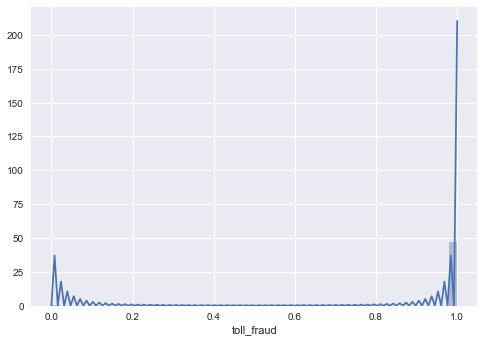

In [20]:
sns.distplot(dataset['toll_fraud'])

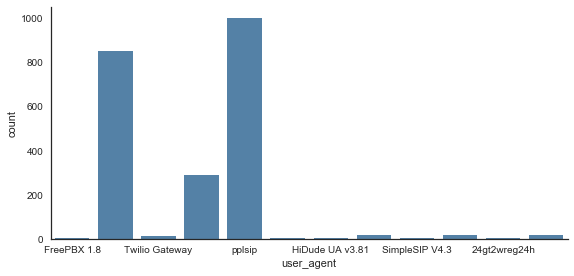

In [37]:
with sns.axes_style('white'):
    g = sns.factorplot("user_agent", data=dataset, aspect=2,
                       kind="count", color='steelblue')
    g.set_xticklabels(step=2)

In [6]:
def _to_string(value):
    """Returns a string type based on value variable type.

    Since we handle multiple languages we need to return a string type to write
    in file human readable character.

    Args:
      value: (None, str or unicode)

    Returns:
      A str or None if no input.
    """

    if not value:
        print('Empty value')
        return None

    if isinstance(value, unicode):
        return value.encode('utf-8')
    else:
        return str(value)

In [7]:
X = None
class HoneypotData(object):
    """Honeypot Data

    This class will contain the entire data pipeline from raw data to prepared
    numpy arrays.  It's eventually inherited by the model class, but is left
    distinct for readbility and logical organization.
    """
    filepath = 'data/'
    train_fn = 'honeypot_dataset.csv'
    test_fn = 'honeypot_test.csv'

    def __init__(self):
        """ Initializes and process all pipeline."""
        self.X_train, self.y_train, self.X_valid, self.y_valid = self.preproc()

    def preproc(self):
        """Process data pipeline."""

        # Import Data & Drop irrelevant features.
        dataset = self.import_data(self.train_fn, drop=True)

        # Fix NA values.
        dataset = self.fix_na(dataset)

        # Feature Engineering.
        dataset = self.engineer_features(dataset)

        # Process Categorical values processing.
        dataset = self.process_categorical(dataset)

        # Select all columns except target.
        X = dataset[dataset.columns.difference([LABEL])]
        y = dataset[LABEL]

        # Split training and test datasets.
        X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=606, stratify=y)
        return X_train.astype('float32'), y_train.values, X_valid.astype('float32'), y_valid.values

    def import_data(self, filename, drop=True):
        """Import that data and then split it into train/test sets. Make sure to stratify.

        This stratify parameter makes a split so that the proportion of values in the sample produced will be the same
        as the proportion of values provided to parameter stratify.
        For example, if variable y is a binary categorical variable with values 0 and 1 and there are 25% of zeros
        and 75% of ones, stratify=y will make sure that your random split has 25% of 0's and 75% of 1's.

        Args:
            filename: (str) filename to read data from as Pandas.dataframe.
            drop: (bool) Drop features.

        Returns:
            A Pandas.dataframe.
        """

        dataset = pd.read_csv('%s%s' % (self.filepath, filename))

        if drop:
            # Drop irrelevant features.
            return dataset.drop(DROPPED_FEATURES, axis=1)
        else:
            return dataset

    def fix_na(self, dataset):
        """Fill na's with test (in the case of contact_user), and with application/sdp in the case of content_type."""

        na_vars = {"contact_user": "test", "content_type": "application/sdp"}
        return dataset.fillna(na_vars)

    def engineer_features(self, dataset):
        """Modify some features."""

        dataset['is_scanner'] = 0  # Initialize to no/0 is scanner.
        dataset['is_scanner'].loc[dataset[_USER_AGENT].isin(SIP_SCANNERS)] = 1  # The rest are 0.
        return dataset

    def process_categorical(self, dataset):
        """

        :param dataset:
        :return:
        """
        # Label Encoding.
        for categorical_feature in LABEL_ENCODED_FEATURES:
            categorical_feature = _to_string(categorical_feature)
            dataset[categorical_feature] = dataset[categorical_feature].astype('category')
            dataset[categorical_feature + '_cat'] = dataset[categorical_feature].cat.codes
        # Drop previous values.
        global X
        X = dataset        
        dataset = dataset.drop(LABEL_ENCODED_FEATURES, axis=1)
        # Rename back categories. {'to_user_cat': 'to_user' ... }
        dataset.rename(columns={c + '_cat': c for c in LABEL_ENCODED_FEATURES}, inplace=True)
        return dataset

    def preproc_test(self):
        """Pre-process testing data."""

        # Import data
        test = self.import_data(self.test_fn, drop=True)
        # Extract labels.
        # Drop previous values.
        test[_USER_AGENT] = test[_USER_AGENT].astype('category')
        test['user_agent_cat'] = test[_USER_AGENT].cat.codes
        print test[['user_agent_cat', _USER_AGENT]].head()
        test = test.drop([_USER_AGENT], axis=1)
        test.rename(columns={'user_agent_cat': _USER_AGENT}, inplace=True)
        labels = test.user_agent.values

        # Fix NA values.
        test = self.fix_na(test)

        # Feature Engineering
        test = self.engineer_features(test)

        # Process Categorical values processing.
        test = self.process_categorical(test)
        print test.columns
        return labels, test

In [8]:
class HoneypotKeras(HoneypotData):
    """Main classifier model based in Keras."""

    def __init__(self):
        self.X_train, self.y_train, self.X_valid, self.y_valid = self.preproc()
        self.y_train, self.y_valid = to_categorical(self.y_train), to_categorical(self.y_valid)
        self.feature_count = self.X_train.shape[1]
        self.history = []

    def build_model(self):
        print 'Feature count: %d' % self.feature_count
        model = Sequential()
        model.add(Dense(2056, input_shape=(self.feature_count,), activation='relu'))
        model.add(Dropout(0.1))
        model.add(Dense(1028, activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(1028, activation='relu'))
        model.add(Dropout(0.3))
        model.add(Dense(512, activation='relu'))
        model.add(Dropout(0.4))
        model.add(Dense(2, activation='sigmoid'))
        model.compile(optimizer='adam',
                      loss='binary_crossentropy',
                      metrics=['accuracy'])
        self.model = model

    def fit(self, lr=0.001, epochs=1):
        self.model.optimizer.lr = lr
        hist = self.model.fit(self.X_train, self.y_train,
                              batch_size=32, epochs=epochs,
                              verbose=1, validation_data=(self.X_valid, self.y_valid),
                              )
        self.history.append(hist)

    def prepare_submission(self, name):
        labels, test_data = self.preproc_test()
        print test_data
        predictions = self.model.predict(test_data)
        subm = pd.DataFrame(np.column_stack([labels, np.around(predictions[:, 1])]).astype('int32'),
                            columns=[_USER_AGENT, LABEL])
        subm.to_csv('%s.csv' % name, index=False)
        return subm

In [9]:
model = HoneypotKeras()
model.build_model()
model.fit(lr=0.01, epochs=1)
#model.fit(lr=0.001, epochs=10)
#model.prepare_submission('keras')

Feature count: 10
Train on 1665 samples, validate on 555 samples
Epoch 1/1
1665/1665 [==============================] - 4s 2ms/step - loss: 0.2614 - acc: 0.9835 - val_loss: 0.0867 - val_acc: 0.9946

In [15]:
X.groupby(['user_agent']).size()

user_agent
24gt2wreg24h                4
Avaya one-X Deskphone     288
Deskphone                  16
FreePBX 1.8                 5
HiDude UA v3.81             2
SimpleSIP V4.3              2
Twilio Gateway             14
caller                     17
eyeBeam release 3006o      18
friendly-scanner            2
pplsip                   1002
sipcli/v1.8               850
dtype: int64